In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import utils
import dataloader
import pandas as pd
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter

In [2]:
tabular_data = pd.read_csv('data.csv')
ds_dict = dataloader.get_split_fold(tabular_data)

'train', 'testA' and 'testB' dataset are stored in the ds_dict, this work, testA is treated as validatin data set for hyperparameter tuning and testB is treated as the test set. 

In [3]:
ds_dict.keys()

dict_keys(['train_ds', 'testA_ds', 'testB_ds'])

With each data sets containing the dictionary that stored the paths to gland image, annotated image and also the patient id. 

In [4]:
ds_dict['train_ds'].keys()

dict_keys(['img_npy', 'anno_npy', 'patient_id'])

# Data loading and Data Augmentation

## Training Data Loading Pipeline
In this work I adopted the data augmentation framework for medical images by MIC-DKFZ.
The data augmentation adopted here is elastic transformation. rotation, image scaling, mirror transformation, brightness transformation, gaussian noise injection, gaussian blur transformation and contrast augmentation with a probability of 0.5.

In [5]:
patch_size = (512, 512)
batch_size = 8
tr_transforms = dataloader.get_train_transform(patch_size)
train_dl = dataloader.DataLoader(data=ds_dict['train_ds'], batch_size=batch_size, patch_size=patch_size,
                                 num_threads_in_multithreaded=4, seed_for_shuffle=5243,
                                return_incomplete=False, shuffle=True, infinite=True)
train_gen = MultiThreadedAugmenter(train_dl, tr_transforms, num_processes=4,
                                   num_cached_per_queue=2,
                                   seeds=None, pin_memory=False)

----------------------------------------------------------------------------------------------------
Batch no.: 0
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



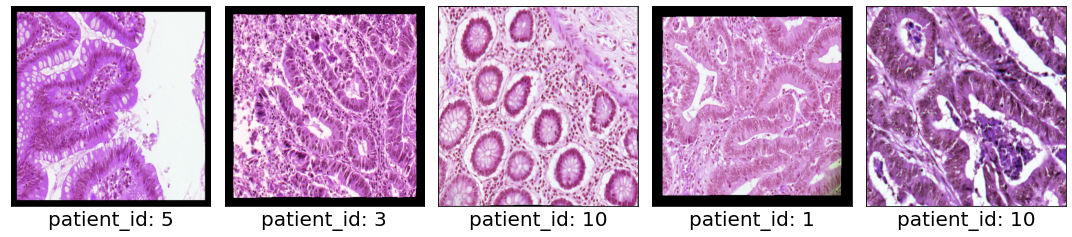

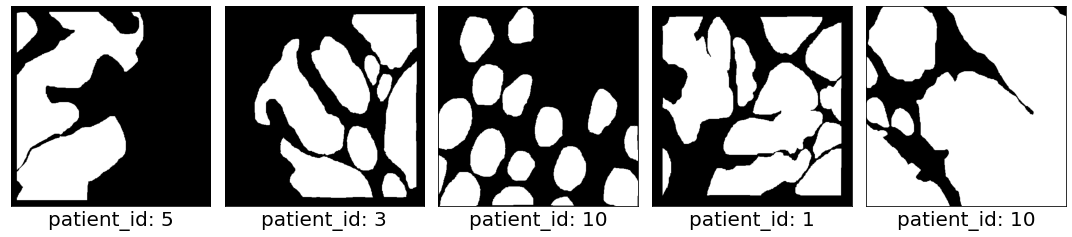

----------------------------------------------------------------------------------------------------
Batch no.: 1
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



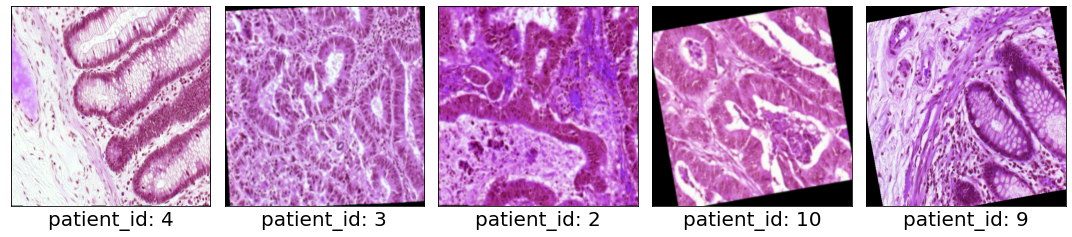

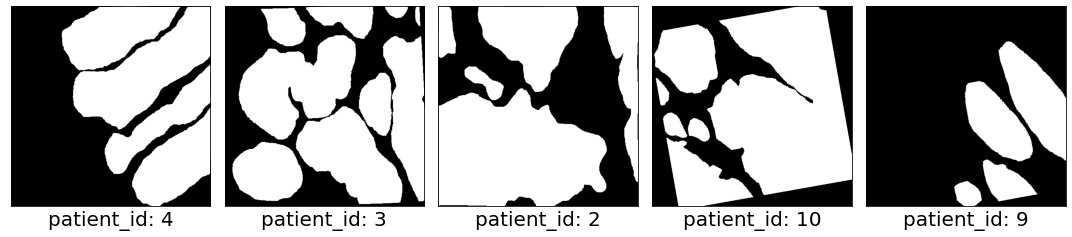

----------------------------------------------------------------------------------------------------
Batch no.: 2
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



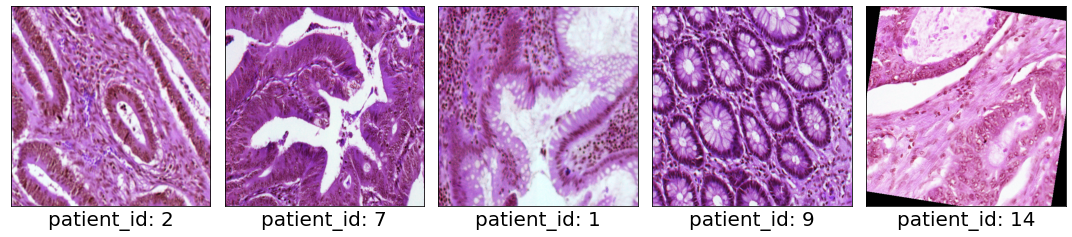

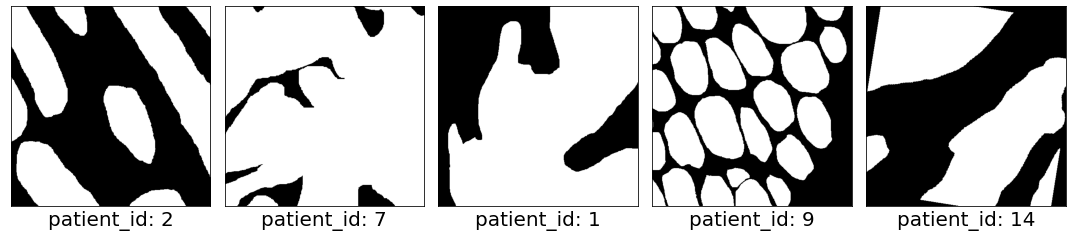

----------------------------------------------------------------------------------------------------
Batch no.: 3
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



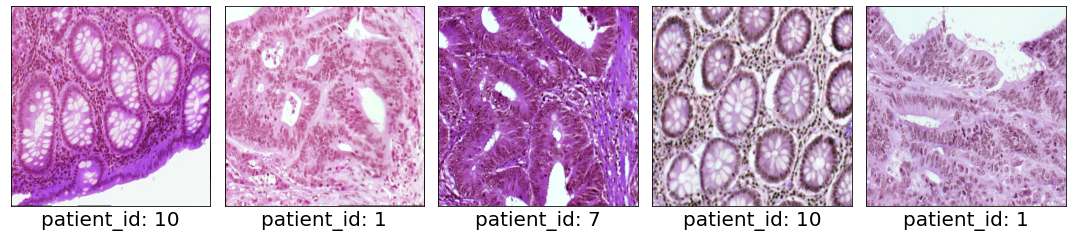

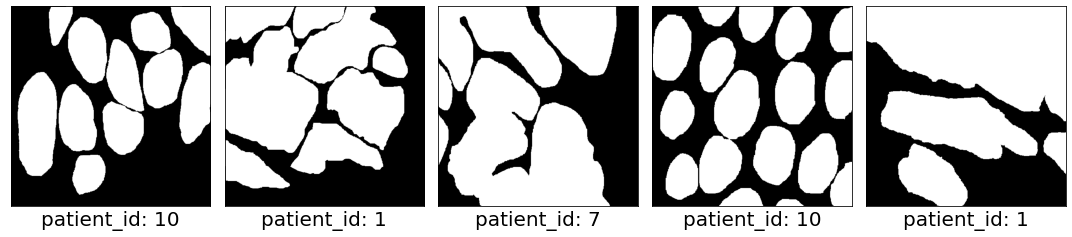

----------------------------------------------------------------------------------------------------
Batch no.: 4
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



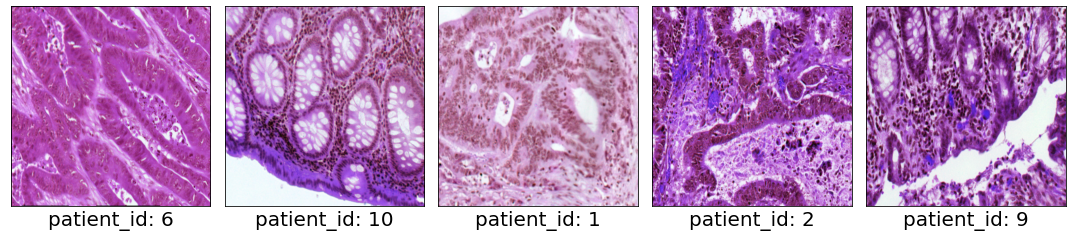

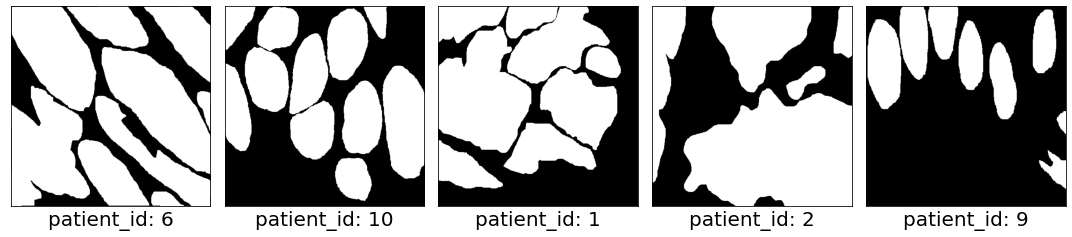

In [13]:
# sanity check for data augmentation techniques for training data set
for i in range(5):
    train_batch = next(train_gen)
    imgs = train_batch['data']
    segs = train_batch['seg']
    patient_id = train_batch['patient_id']
    # tensor manipulation: channel first -> channel last
    imgs = np.einsum('bchw->bhwc', imgs)
    segs = np.einsum('bchw->bhwc', segs)
    # normalization
    imgs = utils.min_max_norm(imgs)
    # binarisation 
    segs = np.where(segs>0., 1.0, 0.).astype('float32')
    print('-'*100)
    print("Batch no.:", i)
    print("Gland Image dimension:", imgs.shape)
    imgs_list = [imgs[i] for i in range(5)]
    print("Gland Image dimension:", segs.shape)
    segs_list = [segs[i] for i in range(5)]
    captions = ['patient_id: {}'.format(patient_id[i]) for i in range(5)]
    utils.plot_comparison(imgs_list, captions, n_col=len(imgs_list), 
                          figsize=(15,15), cmap=None)
    utils.plot_comparison(segs_list, captions, n_col=len(imgs_list), 
                          figsize=(15,15), cmap=None)

## Validation Data Loading Pipeline
Data augmentation was not adopted for validation and test set 

In [7]:
tmp = np.ones((8, 3, 512, 512))
tmp = np.expand_dims(tmp[:,0,:,:], 1)
print(tmp.shape)

(8, 1, 512, 512)


In [8]:
val_dl = dataloader.DataLoader(data=ds_dict['testA_ds'], batch_size=batch_size, patch_size=patch_size,
                                 num_threads_in_multithreaded=4, seed_for_shuffle=5243,
                                return_incomplete=False, shuffle=True, infinite=True)

----------------------------------------------------------------------------------------------------
Batch no.: 0
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



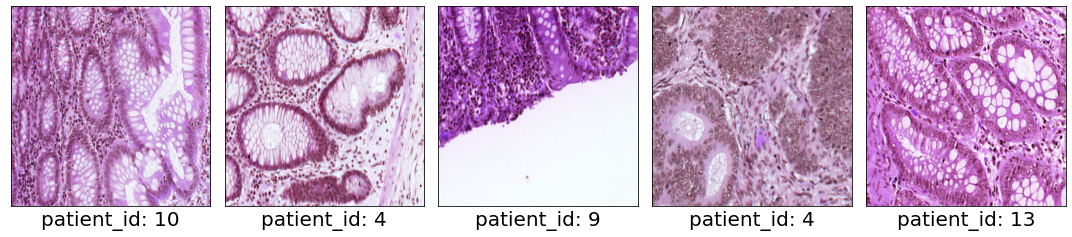

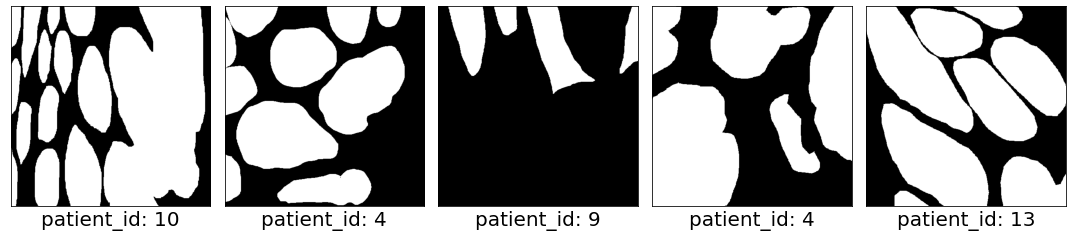

----------------------------------------------------------------------------------------------------
Batch no.: 1
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



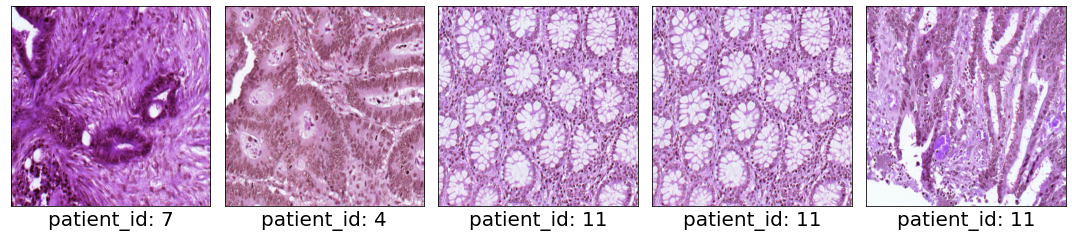

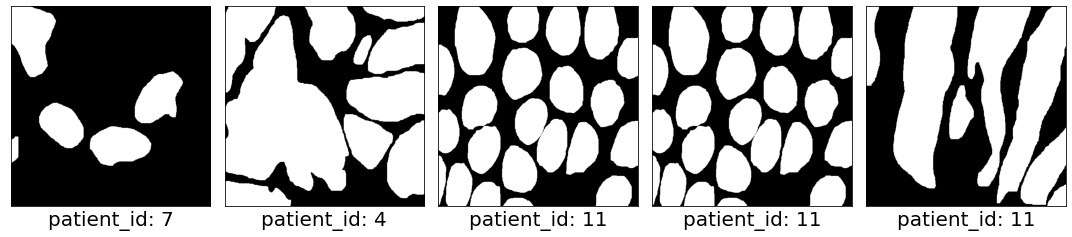

----------------------------------------------------------------------------------------------------
Batch no.: 2
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



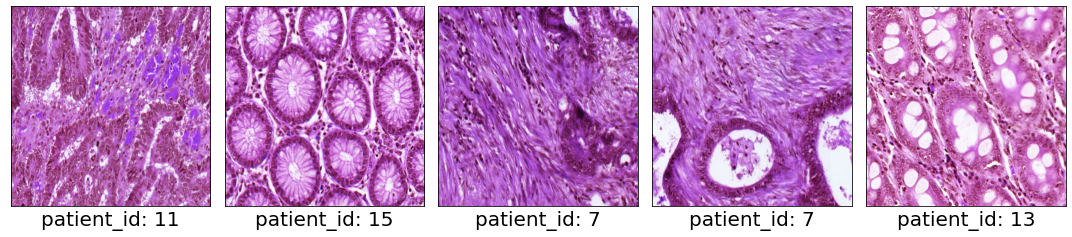

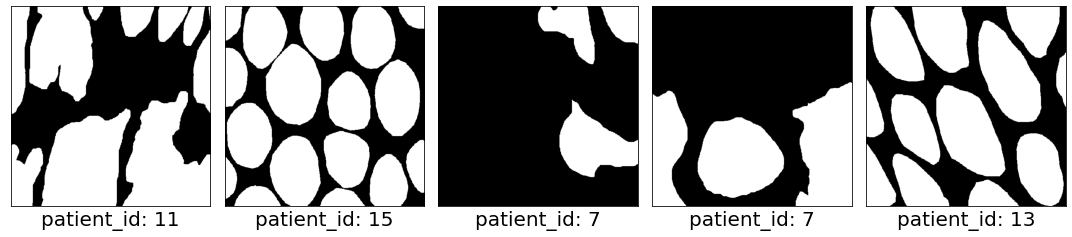

----------------------------------------------------------------------------------------------------
Batch no.: 3
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



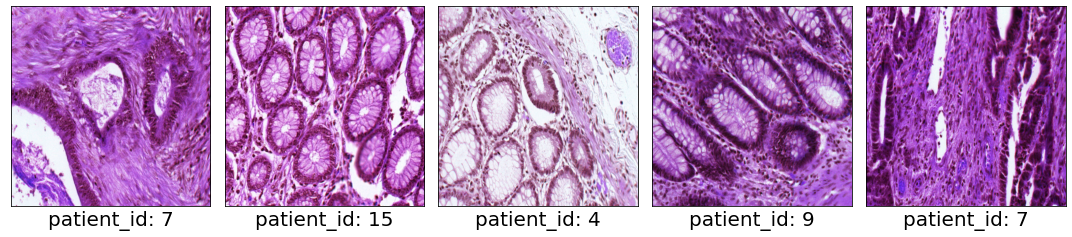

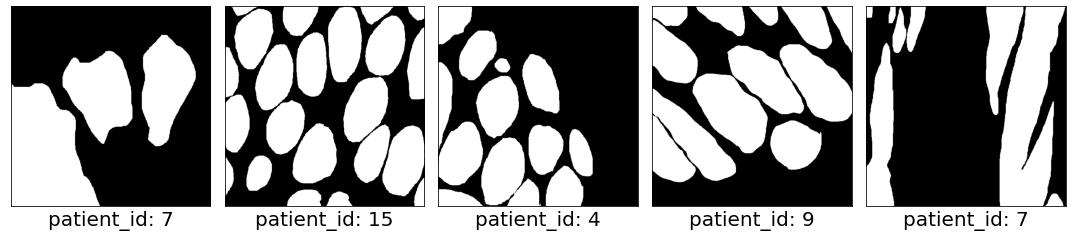

----------------------------------------------------------------------------------------------------
Batch no.: 4
Gland Image dimension: (8, 512, 512, 3)
Gland Image dimension: (8, 512, 512, 3)



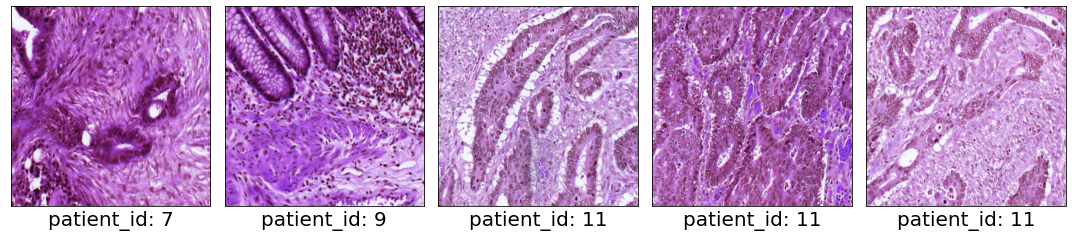

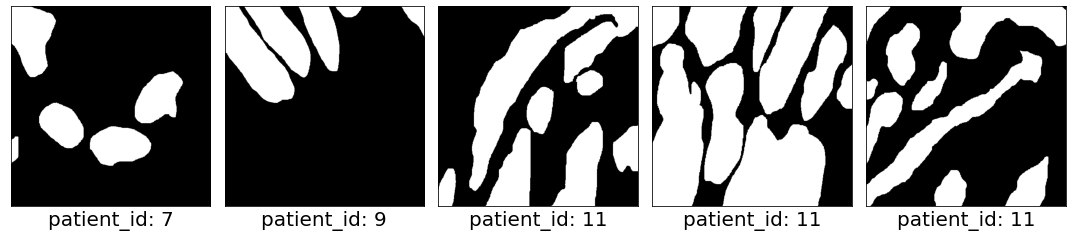

In [9]:
# sanity check for validation data pipeline 
for i in range(5):
    val_batch = next(val_dl)
    imgs = val_batch['data']
    segs = val_batch['seg']
    patient_id = val_batch['patient_id']
    # tensor manipulation: channel first -> channel last
    imgs = np.einsum('bchw->bhwc', imgs)
    segs = np.einsum('bchw->bhwc', segs)
    # normalization
    imgs = utils.min_max_norm(imgs)
    # binarisation 
    segs = np.where(segs>0., 1.0, 0.)
    print('-'*100)
    print("Batch no.:", i)
    print("Gland Image dimension:", imgs.shape)
    imgs_list = [imgs[i] for i in range(5)]
    print("Gland Image dimension:", segs.shape)
    segs_list = [segs[i] for i in range(5)]
    captions = ['patient_id: {}'.format(patient_id[i]) for i in range(5)]
    utils.plot_comparison(imgs_list, captions, n_col=len(imgs_list), 
                          figsize=(15,15), cmap=None)
    utils.plot_comparison(segs_list, captions, n_col=len(imgs_list), 
                          figsize=(15,15), cmap=None)